### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework. 
### Radmehr Ghassabtabarshiadeh

Part A

A/B testing to determine whether SHVR or ZIC traders perform better using BSE market sessions simulation to est the null hypothesis that there is no signifacnt difference between the two traders and the alternative hypothesis of there being a signifacnt difference between the two traders with the significance value set to 0.05. A market session will run with the specification mentioned on the brief with start time and end time are set to 0 and 600 respectively. After the simulation are complete, two data frames are created, one with everything the "dump_avgbals" creates and another only taking in the accumilated average profit of each trader. To test the hypothesis, t-test was used, this test allows to see whether the observed differences are statistically significant. Some helper functions are below to help do what was described. The functions "make_df" and "collect_avg_profit" are helper functions for "run_market_sim" which create a dataframe and grab the average profit for the two traders after each market session. The collected averages, are plotted to understand their distribution using "kdeplot" and to understand whether further normalisation is rquired or not. The data then is passed in a  t-test where the p value is returned.

In [144]:
# Some code...
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
from scipy import stats
import pandas as pd
import seaborn as sns 

from BSE import market_session

def make_df(path: str):
    df = pd.read_csv(path)
    df.columns =  ['name', 'time', 'curr best bid', 'curr best offer', 'trader1', 'total profit1', 'no. 1', 'avg profit1', 'trader2', 'total profit2', 'no. 2', 'avg profit2', 'err']
    df_profit = df[['avg profit1', 'avg profit2']]
    df_profit.columns = ['SHVR', 'ZIC']
    return df, df_profit

def collect_avg_profit(df):
    _zic = df['ZIC'][len(df)-1]
    _shvr = df['SHVR'][len(df)-1]
    return _zic, _shvr

def trader_specs_two(R, n):
    SHVR_num = (n*R)//100
    zic_num = ((100-R)*n)//100
    buyer_spec = [('SHVR', SHVR_num), ('ZIC', zic_num)]
    seller_spec = [('SHVR', SHVR_num), ('ZIC', zic_num)]
    trader_specs = {'sellers': seller_spec, 'buyers': buyer_spec}
    return trader_specs

def run_market_sim(trial_id, no_sessions, R, n, supply_range, demand_range, start_time, end_time, path):
    trader_specs = trader_specs_two(R, n)
    total_avg_zic = []
    total_avg_shvr = []
    
    for _ in range(no_sessions):
        supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
        demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
        order_interval = 60
        order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                    'interval': order_interval, 'timemode': 'periodic'}
        dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
                            'dump_avgbals': True, 'dump_tape': False}

        verbose = False
        market_session(trial_id, start_time, end_time, trader_specs, order_sched, dump_flags, verbose)
        _, df_profit = make_df(path)
        _zic, _shvr = collect_avg_profit(df_profit)
        total_avg_shvr.append(_shvr)
        total_avg_zic.append(_zic)
    
    return total_avg_shvr, total_avg_zic

In [164]:
n500mean_shvr, n500mean_zic = run_market_sim(trial_id="n500", no_sessions=500, R=50, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=60*10, path='n500_avg_balance.csv')
n50mean_shvr, n50mean_zic = run_market_sim(trial_id="n50", no_sessions=50, R=50, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=60*10, path='n50_avg_balance.csv')

Seaborn library is used to visualise the data frame to determine wheteher the average profit is normaly distributed or not. As the output show, the data is somewhat normally distributed and can be passed for t-test without the need for furthur normalisation. Ttest makes the assumption that the variance of the both data set is roughly the same which is the case for both 50 and 500 sessions data collected.

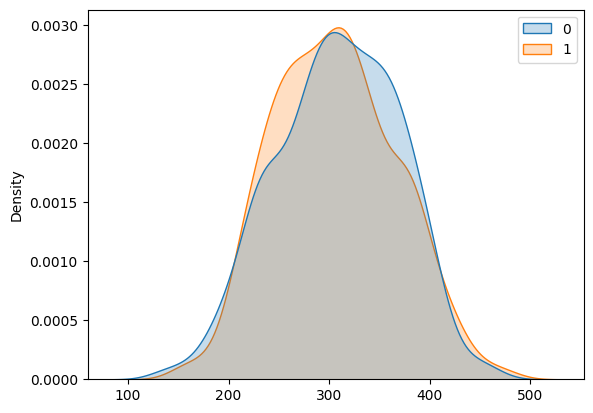

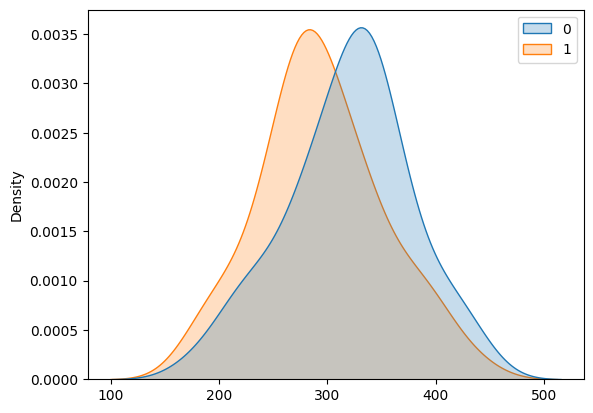

3644.8872409999994 3689.30987091
3190.1112000000007 3204.296425


In [165]:
plot_500 = sns.kdeplot([n500mean_zic, n500mean_shvr])
plt.show()
plot_50 = sns.kdeplot([n50mean_zic, n50mean_shvr])
plt.show()
print(np.var(n500mean_shvr), np.var(n500mean_zic))
print(np.var(n50mean_shvr), np.var(n50mean_zic))

In [167]:
_, p_val50 = stats.ttest_ind(n50mean_zic, n50mean_shvr)
print(p_val50, '50 sessions')
_, p_val500 = stats.ttest_ind(n500mean_zic, n500mean_shvr)
print(p_val500, '500 sessions')

0.03349086814120634 50 sessions
0.4834944963785327 500 sessions


In [154]:
count = 0
for i in range(len(n500mean_zic)):
    if n500mean_zic[i] > n500mean_shvr[i]:
        count += 1
print(count)

242


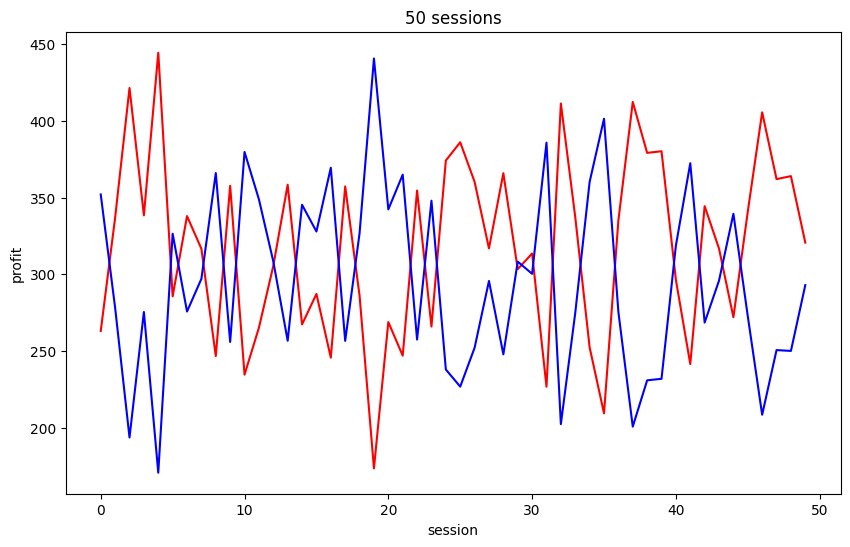

Text(0, 0.5, 'profit')

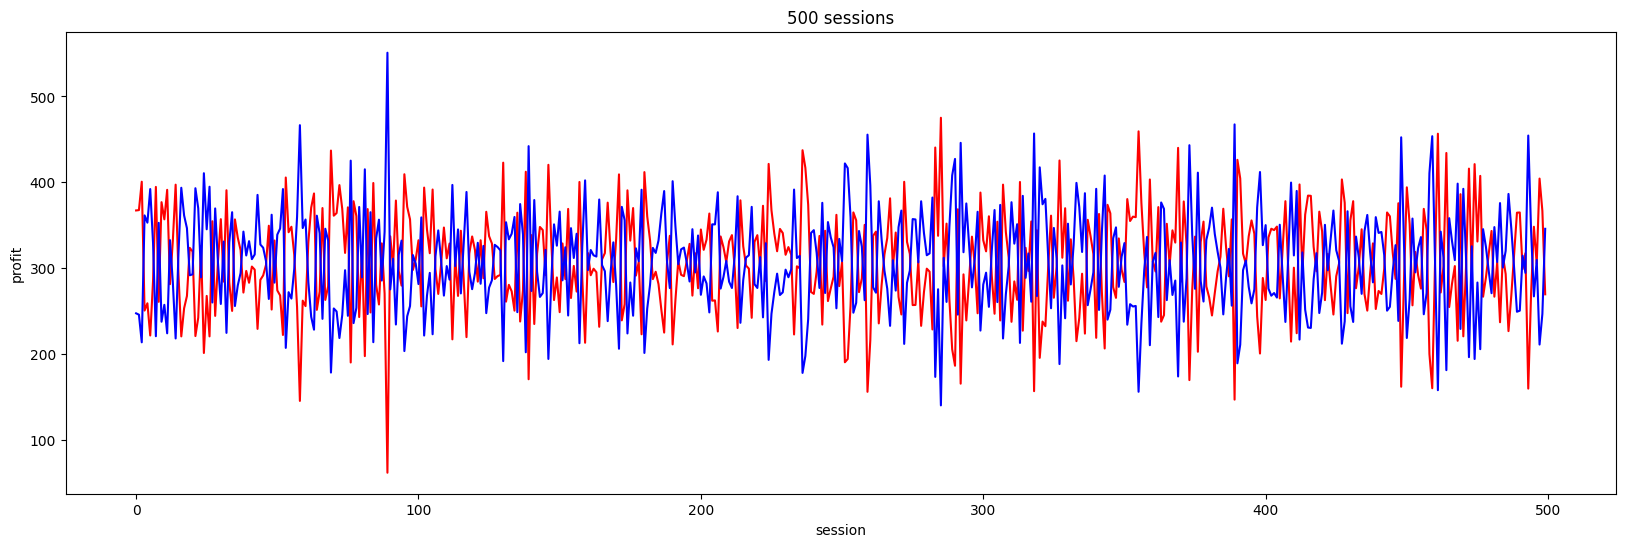

In [155]:
plt.figure(figsize=(10, 6))
plt.plot(n50mean_zic, 'r', n50mean_shvr, 'b')
plt.title('50 sessions')
plt.xlabel('session')
plt.ylabel('profit')
plt.show()
plt.figure(figsize=(20, 6))
plt.plot(n500mean_zic, 'r', n500mean_shvr, 'b')
plt.title('500 sessions')
plt.xlabel('session')
plt.ylabel('profit')

The P value for when ther are 50 market sessions is 0.63 suggesting that there are no significant differences between the traders, however the data suggests that shvr traders perform consistantly better than the zic traders as they have an accumilated more average profit per session. This is further reinforced when the market session are increased to 500. the p value becomes lower than the threshold, suggesting that there is enough evidence to reject the null hypothesis and conclude that SHVR trader are in fact superior to zic traders in this market.

PART B

In [70]:
def R_market_run(R, no_sessions, n, supply_range, demand_range, start_time, end_time):
    res = []
    tmp = "n" + str(no_sessions) + "_"
    for r in R:
        trial_id = tmp + str(r)
        path = str(trial_id) + "_avg_balance.csv"
        res.append(run_market_sim(trial_id, no_sessions, r, n, supply_range, demand_range, start_time, end_time, path))

    return res

In [71]:
R = [10, 20, 30, 40, 50, 60, 70, 80, 90]

res50 = R_market_run(R, 50, 20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60) #50 arr, each 2 array of 50 inside res[n][0] = zic, res[n][1] = shvr
res500 = R_market_run(R, 500, 20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60) #same as above but 500

In [100]:
p_vals_50 = []
for i in range(len(res50)):
    _, p_50 = stats.ttest_ind(res50[i][0], res50[i][1])
    p_vals_50.append(p_50)

p_vals_500 = []
for i in range(len(res500)):
    _, p_500 = stats.ttest_ind(res500[i][0], res500[i][1])
    p_vals_500.append(p_500)

print(p_vals_50)
print(p_vals_500)

[0.0003457239412318154, 0.23298190386424034, 0.2531283445016012, 0.6160496467432811, 0.34803620066229823, 0.13685887356341472, 0.543614350751831, 0.25283972934448756, 0.15019605793155721]
[1.1194234785784124e-06, 0.00041362600421229, 0.06569870763758985, 0.8099979312668155, 0.032169911514526625, 0.25819009910664026, 0.0039819841148177534, 0.029264031436300925, 0.40469542087375243]


In [102]:
def anova_test(df):
    shvr_avg = df['SHVR']
    gvwy_avg = df['GVWY']
    zic_avg = df['ZIC']
    zip_avg = df['ZIP']
    _, p = stats.f_oneway(shvr_avg, gvwy_avg, zic_avg, zip_avg)
    return p

def collect_mean_4(df):
    mean_zic = df['ZIC'][len(df)-1]
    mean_shvr = df['SHVR'][len(df)-1]
    mean_GVWY = df['GVWY'][len(df)-1]
    mean_zip = df['ZIP'][len(df)-1]
    return mean_shvr, mean_GVWY, mean_zic, mean_zip

def df_four(path):
    df = pd.read_csv(path)
    df.columns =  ['name', 'time', 'curr best bid', 'curr best offer', 'trader1', 'total profit1', 'no. 1', 'avg profit1', 'trader2', 'total profit2', 'no. 2', 'avg profit2',
                   'trader3', 'total profit3', 'no. 3', 'avg profit3', 'trader4', 'total profit4', 'no. 4', 'avg profit4', 'err']
    df_profit = df[['avg profit1', 'avg profit2', 'avg profit3', 'avg profit4']]
    df_profit.columns = ['GVWY', 'SHVR', 'ZIC', 'ZIP']
    return df, df_profit    

def four_trader_specs(t: list, n: int):
    res = []
    for i in range(len(t)):
        t = np.roll(t, i)
        tmp = []
        for x in t:
            tmp.append(int(x))
        t = tmp
        shvr_num = (t[0]*n)/100
        gvwy_num = (t[1]*n)/100
        zic_num = (t[2]*n)/100
        zip_num = (t[3]*n)/100
        buyer_specs = [('SHVR', int(shvr_num)), ('GVWY', int(gvwy_num)), ('ZIC', int(zic_num)), ('ZIP', int(zip_num))]
        seller_specs = [('SHVR', int(shvr_num)), ('GVWY', int(gvwy_num)), ('ZIC', int(zic_num)), ('ZIP', int(zip_num))]
        trader_specs = {'sellers': seller_specs, 'buyers': buyer_specs}
        res.append(trader_specs)
    return res

def run_market_sim_four(trial_id, no_sessions, t, n, supply_range, demand_range, start_time, end_time):

    if t == [25, 25, 25, 25]:
        mean_shvr_t = []
        mean_GVWY_t = []
        mean_zic_t = []
        mean_zip_t = []
        seller_spec = [('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
        buyer_spec = [('SHVR', 5), ('GVWY', 5), ('ZIC', 5), ('ZIP', 5)]
        trader_specs = {'sellers': seller_spec, 'buyers': buyer_spec}
        path = str(trial_id) + "_avg_balance.csv"
        for _ in range(no_sessions):
            supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
            demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
            order_interval = 60
            order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                            'interval': order_interval, 'timemode': 'periodic'}
            dump_flags = {'dump_blotters': True, 'dump_lobs': True, 'dump_strats': True,
                            'dump_avgbals': True, 'dump_tape': True}
            verbose = False
            market_session(trial_id, start_time, end_time, trader_specs, order_sched, dump_flags, verbose)
            _, df_profit = df_four(path)
            mean_shvr, mean_GVWY, mean_zic, mean_zip = collect_mean_4(df_profit)
            mean_shvr_t.append(mean_shvr)
            mean_GVWY_t.append(mean_GVWY)
            mean_zic_t.append(mean_zic)
            mean_zip_t.append(mean_zip)
    else:
        trader_specs = four_trader_specs(t, n)

        for i, ts in enumerate(trader_specs):
            mean_shvr_t = []
            mean_GVWY_t = []
            mean_zic_t = []
            mean_zip_t = []
            trial_id = trial_id + str(i) + "_shift"
            path = str(trial_id) + "_avg_balance.csv"
            for _ in range(no_sessions):
                supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supply_range], 'stepmode': 'fixed'}]
                demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demand_range], 'stepmode': 'fixed'}]
                order_interval = 60
                order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
                            'interval': order_interval, 'timemode': 'periodic'}
                dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
                            'dump_avgbals': True, 'dump_tape': False}
                verbose = False
                market_session(trial_id, start_time, end_time, ts, order_sched, dump_flags, verbose)
                _, df_profit = df_four(path)
                mean_shvr, mean_GVWY, mean_zic, mean_zip = collect_mean_4(df_profit)
                mean_shvr_t.append(mean_shvr)
                mean_GVWY_t.append(mean_GVWY)
                mean_zic_t.append(mean_zic)
                mean_zip_t.append(mean_zip)

            
    return mean_shvr_t, mean_GVWY_t, mean_zic_t, mean_zip_t

In [103]:
t = [25, 25, 25, 25]
t1 = [40, 20, 20, 20]
t2 = [10, 30, 30, 30]
t3 = [70, 10, 10, 10]

r150_shvr, r150_gvwy, r150_zic, r150_zip = run_market_sim_four("same50", no_sessions=50, t=t, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r250_shvr, r250_gvwy, r250_zic, r250_zip = run_market_sim_four("forty50", no_sessions=50, t=t1, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r350_shvr, r350_gvwy, r350_zic, r350_zip = run_market_sim_four("ten50", no_sessions=50, t=t2, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r450_shvr, r450_gvwy, r450_zic, r450_zip = run_market_sim_four("seventy50", no_sessions=50, t=t3, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)

r1500_shvr, r1500_gvwy, r1500_zic, r1500_zip = run_market_sim_four("same500", no_sessions=500, t=t, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r2500_shvr, r2500_gvwy, r2500_zic, r2500_zip = run_market_sim_four("forty500", no_sessions=500, t=t1, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r3500_shvr, r3500_gvwy, r3500_zic, r3500_zip = run_market_sim_four("ten500", no_sessions=500, t=t2, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)
r4500_shvr, r4500_gvwy, r4500_zic, r4500_zip = run_market_sim_four("seventy500", no_sessions=500, t=t3, n=20, supply_range=(310, 310), demand_range=(250, 490), start_time=0, end_time=10*60)

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT. 

In [18]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

C:\Users\Radur\AppData\Local\Temp\ipykernel_7980\1902107979.py:3: DeprecationWarning: nbformat.current is deprecated since before nbformat 3.0

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  from nbformat import current


In [19]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "CW-IEFT-template.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 333. Limit is 2000 words.
